### Imports, rc settings, ipython magic commands

In [18]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import rasterio as rio
import skimage.measure
import pandas as pd

from dateutil import tz
from matplotlib.dates import DateFormatter
from matplotlib.patches import Rectangle

matplotlib.rc('figure', dpi=150)

### Define the coastal HAND function

In [19]:
def coastal_hand_where(src, riv_inun, gage_el_navd88, opix):
    """
    Returns inundation array of the same shape as src.
        Parameters:
            src : ndarray
                2D float array containing terrain elevation data
            gage_el : float
                Constant water surface elevation to apply to DEM
            opix : (int, int)
                Tuple with (row, col) of an ocean cell in src 
    """
    # initialize array with nan values
    src_inun = np.empty_like(src)
    src_inun.fill(np.nan) 
    # where src (the DEM) has an elevation greater than or equal to the gage elev.
    # assign an inundation elev. of 0 to src_inun (array that will become the inundation raster)
    # otherwise assign inundation elev. of gage elev. - DEM surface elevation
    src_inun = np.where(src >= (gage_el_navd88), \
                        0, (gage_el_navd88) - src)
    # masked array with a value of 255 at all inundated cells and 0 at all dry cells
    inun_mask = np.where(src_inun==0,0,255)
    # label connected groups of inundated cells ("blobs")
    blobs = skimage.measure.label(inun_mask)
    # find blob that contains the ocean pixel, which must be inundated
    blob = blobs[opix] # opix is row, col
    # keep only the blob containing the ocean pixel, uninundate all other blobs
    # because they are not hydraulically connected to the ocean
    src_inun = np.where(blobs==blob,src_inun,0) # blobs==1 are cells of biggest blob
    # compound riverine-surge inundation combined with max method
    # src_inun_riv = np.where(src_inun <= riv_inun, riv_inun, src_inun) 
    # return masked array if fed one
    if isinstance(src, np.ma.MaskedArray):
        # src_inun_riv = np.ma.masked_array(src_inun_riv, src.mask)
        src_inun = np.ma.masked_array(src_inun, src.mask)
        
    # mask out zero inundation cells for visualization
    # src_inun_riv = np.ma.masked_where(src_inun_riv==0,src_inun_riv,copy=True)
    
    # return src_inun_riv
    return src_inun

### Plot New Bern sea water elev. time series

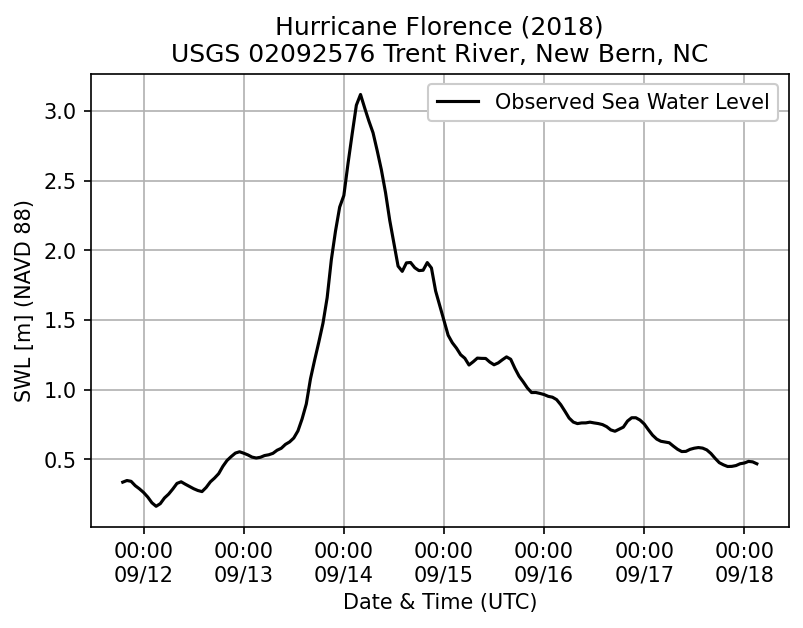

In [ ]:
usgs_newbern_florence = pd.read_csv(
    'data_github/usgs_newbern_florence.txt',
    header=26,
    skiprows=[27],
    sep='\t',
    usecols=['datetime','89316_62620'],
    parse_dates=['datetime']
)

# make UTC timestamp index & clean up
usgs_newbern_florence.index = usgs_newbern_florence.datetime
tzEDT = tz.tzoffset('UTC', -4*3600) # make custom offset for EDT (UTC-4)
usgs_newbern_florence.index = usgs_newbern_florence.index.tz_localize(tzEDT)
usgs_newbern_florence.index = usgs_newbern_florence.index.tz_convert('UTC')
usgs_newbern_florence = usgs_newbern_florence.drop(columns='datetime')
usgs_newbern_florence.columns = ['wsl_m_navd88']
usgs_newbern_florence.wsl_m_navd88 = usgs_newbern_florence.wsl_m_navd88 * 0.3048 # ft to m
usgs_newbern_florence = usgs_newbern_florence.resample('1H').mean() # resample from 6-min to hourly

plt.close('all')

fig, ax = plt.subplots()

ax.plot(
    usgs_newbern_florence.index,    
    usgs_newbern_florence.wsl_m_navd88,
    'k-',
    label='Observed Sea Water Level'
)

date_form = DateFormatter("%H:%M\n%m/%d")
ax.xaxis.set_major_formatter(date_form)
ax.legend(framealpha=1)
ax.set(
    xlabel='Date & Time (UTC)',
    ylabel='SWL [m] (NAVD 88)',
    title='Hurricane Florence (2018)\nUSGS 02092576 Trent River, New Bern, NC'
)

plt.grid()
plt.show()
fig.tight_layout()

### Read in DEM and show with ocean pixel location

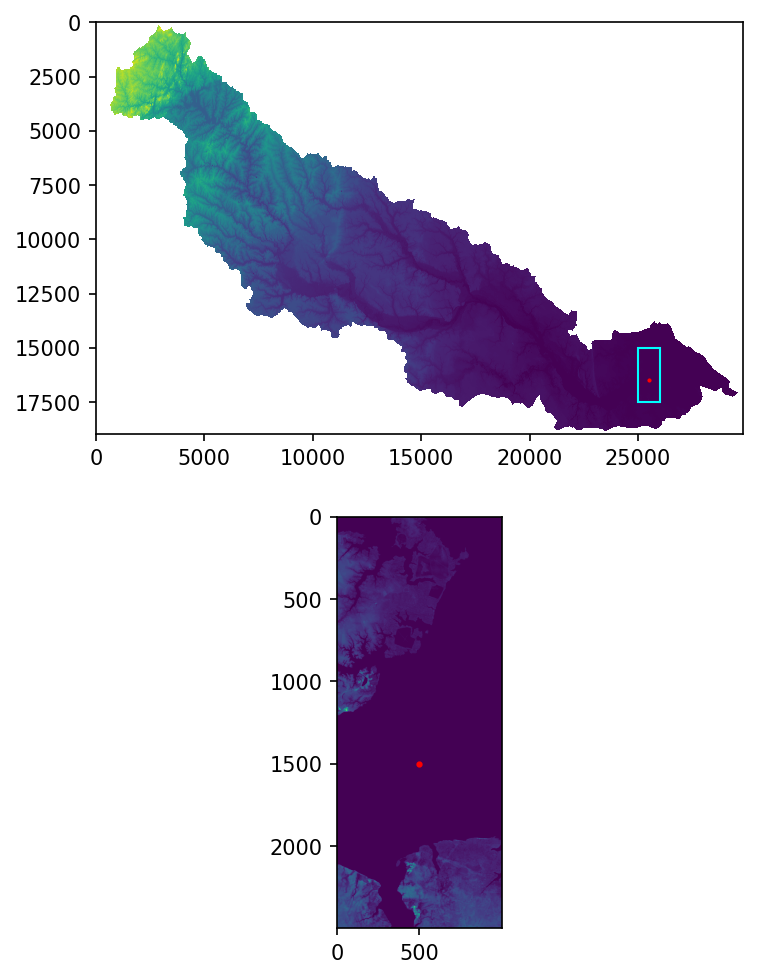

In [20]:
# data for initial plot
with rio.open('data_github/nc_roi_huc6.tif') as ds_in:
    dem = ds_in.read(1, masked=True)
    in_profile = ds_in.profile
    in_profile['compress'] = 'lzw'
    msk = dem.copy().mask # save mask, will get wiped out on next line
    dem[dem<0] = 0
    dem = np.ma.masked_array(dem, msk)

# plot dem, zoom in on coast, find and show ocean pixel
plt.close('all')

rec_tl = (25000,15000) # x, y
dw, dh = 1000, 2500 # width, height of rec

opix = (25500,16500) # x, y
opix_col, opix_row = opix
ax1_opix_col, ax1_opix_row = np.subtract(opix,rec_tl)

fig, ax = plt.subplots(2,1,figsize=(6,8))

ax[0].imshow(
    dem,
    vmin=-0,
    vmax=250
    )
ax[0].add_patch(Rectangle(
    rec_tl,
    dw,dh,
    fill=False,
    color='cyan')
    )
ax[0].plot(opix_col, opix_row,'ro',markersize=1) # (x,y) is (col,row)

ax[1].imshow(
    dem[
        rec_tl[1]:rec_tl[1]+dh,
        rec_tl[0]:rec_tl[0]+dw
        ]
        )
ax[1].plot(
    ax1_opix_col, ax1_opix_row,
    'ro',markersize=2
    )

### Write timeseries to rasters

In [36]:
w_msk = (~msk * 255).astype('uint8')
for i, swl in enumerate(usgs_newbern_florence['wsl_m_navd88']):
    timestamp = str(usgs_newbern_florence.index[i])[:-6].replace(':','.')
    inun_surge_navd = coastal_hand_where(dem, None, swl, ocean_pixel)
    with rio.open(f'data_github/coastal_inun_{timestamp}.tif', 'w', **in_profile) as ds_out:
        ds_out.write(inun_surge_navd,1)
        ds_out.write_mask(w_msk)
    del(inun_surge_navd)